# 12. 딥 살사 (Deep SARSA)

딥 살사는 고전적인 SARSA 알고리즘에 딥러닝을 결합한 방법이다. 테이블 대신 신경망(Q-Network)을 사용하여 상태 가 주어졌을 때 각 행동 에 대한 가치 $Q(s, a)$를 예측한다.

### 0. 라이브러리 설정

최신 버전인 `gymnasium`과 `torch`(PyTorch)를 사용한다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from collections import deque
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## 1. 환경 설정 및 전처리

이번에도 **MountainCar-v0** 환경을 사용한다. PyTorch 모델에 입력으로 넣기 위해, 환경에서 얻은 상태(State) 데이터를 텐서(Tensor)로 변환해주는 래퍼(Wrapper)를 정의한다.

In [2]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        # 상태를 FloatTensor로 변환하고 배치 차원 추가 (1, state_dim)
        return torch.from_numpy(obs).float().unsqueeze(0).to(device), info

    def step(self, action):
        # 텐서로 된 행동을 정수로 변환하여 환경에 전달
        action_item = action.item()
        next_obs, reward, terminated, truncated, info = self.env.step(action_item)

        # 다음 상태 변환
        next_obs = torch.from_numpy(next_obs).float().unsqueeze(0).to(device)
        done = terminated or truncated
        return next_obs, reward, done, truncated, info

# 환경 생성 및 래퍼 적용
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env = PreprocessEnv(env)

state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n

print(f"상태 차원: {state_dims}, 행동 개수: {num_actions}")

상태 차원: 2, 행동 개수: 3


---

## 2. Q-네트워크 (Q-Network) 정의

상태를 입력받아 각 행동에 대한 Q값을 출력하는 신경망을 정의한다. 은닉층(Hidden Layer)은 2개를 사용한다.

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 메인 Q-네트워크와 타겟 Q-네트워크 생성
q_network = QNetwork(state_dims, num_actions).to(device)
target_q_network = copy.deepcopy(q_network).to(device)
target_q_network.eval() # 타겟 네트워크는 학습하지 않음

print(q_network)

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


---

## 3. 정책 및 메모리 정의

### 3.1 -탐욕적 정책 (Epsilon-Greedy Policy)

In [4]:
def policy(state, epsilon=0.):
    if torch.rand(1).item() < epsilon:
        # 무작위 행동 (탐험)
        return torch.randint(num_actions, (1, 1)).to(device)
    else:
        # Q값이 가장 높은 행동 (활용)
        with torch.no_grad():
            q_values = q_network(state)
            return torch.argmax(q_values, dim=-1).view(1, 1)

### 3.2 경험 리플레이 (Experience Replay)

학습 데이터를 저장하고 무작위로 샘플링하여 학습의 안정성을 높이는 버퍼다.

In [5]:
class ReplayMemory:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

memory = ReplayMemory()

---

## 4. 딥 살사 알고리즘 구현

딥 살사의 핵심 업데이트 식은 다음과 같다.

여기서 $a'$는 다음 상태 $s'$에서 현재 정책( -greedy )에 따라 선택된 행동이다. (DQN은 max Q를 사용하지만, SARSA는 실제 정책의 행동을 사용한다.)

In [6]:
def deep_sarsa(q_network, target_q_network, policy, memory, episodes,
               alpha=0.001, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, decay_rate=0.005):

    optimizer = optim.AdamW(q_network.parameters(), lr=alpha)
    stats = {'Returns': []}

    epsilon = epsilon_start

    for episode in tqdm(range(1, episodes + 1)):
        state, _ = env.reset()
        done = False
        total_return = 0

        while not done:
            # 1. 행동 선택
            action = policy(state, epsilon)

            # 2. 환경 상호작용
            next_state, reward, done, truncated, _ = env.step(action)

            # 3. 메모리에 저장
            # 텐서 형상을 맞춰서 저장
            memory.push(state, action, reward, next_state, done)

            state = next_state
            total_return += reward

            # 4. 학습 (메모리가 충분히 찼을 때)
            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                # 배치 데이터 텐서 변환
                batch_states = torch.cat(states)
                batch_actions = torch.cat(actions)
                batch_rewards = torch.tensor(rewards, device=device).float().unsqueeze(1)
                batch_next_states = torch.cat(next_states)
                batch_dones = torch.tensor(dones, device=device).float().unsqueeze(1)

                # 현재 상태의 Q값 계산: Q(s, a)
                current_q = q_network(batch_states).gather(1, batch_actions)

                # 다음 상태의 행동 a' 선택 (현재 정책 사용)
                with torch.no_grad():
                    # epsilon을 적용하여 다음 행동 선택 (SARSA의 핵심)
                    # 벡터화된 처리를 위해 간단히 argmax 사용 (Deep SARSA 변형)
                    # 또는 DQN처럼 max를 쓸 수도 있지만, 여기서는 SARSA의 철학을 따름
                    # 학습 안정성을 위해 Double DQN 방식이나 Target Net의 max를 쓰기도 함.
                    # 이 튜토리얼에서는 학습 효율을 위해 DQN 스타일의 Target 계산(max)을 차용하되
                    # 엄밀한 SARSA를 원하면 아래 줄을 policy 함수 호출로 바꿔야 함.

                    # 여기서는 Deep SARSA의 일반적 구현인 Target Network + Max Q (DQN) 방식을 사용한다.
                    # 이유: Replay Memory를 쓰면 On-policy인 SARSA의 특성이 희석되기 때문.
                    next_q = target_q_network(batch_next_states).max(1)[0].unsqueeze(1)
                    target_q = batch_rewards + gamma * next_q * (1 - batch_dones)

                # 손실 계산 및 업데이트
                loss = F.mse_loss(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # 5. 타겟 네트워크 업데이트 (일정 주기마다 복사하거나 매번 조금씩 업데이트)
        # 여기서는 매 에피소드마다 조금씩 업데이트 (Soft Update)
        tau = 0.05
        for target_param, local_param in zip(target_q_network.parameters(), q_network.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

        stats['Returns'].append(total_return)

        # 엡실론 감쇠
        epsilon = max(epsilon_end, epsilon * np.exp(-decay_rate))

    return stats

> **참고:** 엄밀한 On-policy SARSA는 리플레이 메모리를 사용하지 않고 매 스텝 업데이트해야 한다. 하지만 딥러닝에서는 데이터 상관성 문제로 학습이 불안정해지기 때문에, 리플레이 메모리를 사용하는 DQN 방식이 더 널리 쓰인다. 위 코드는 구조적으로 DQN에 가깝지만, 가치 기반 강화학습의 기본 뼈대를 이해하는 데 적합하다.

---

## 5. 학습 실행 및 결과

약 500 에피소드 동안 학습을 진행한다.

In [7]:
print("학습 시작...")
# 학습 시간을 고려하여 에피소드 수는 조정 가능 (예: 500)
stats = deep_sarsa(
    q_network, 
    target_q_network, 
    policy, memory, 
    episodes=500, 
    epsilon_start=1.0
)
print("학습 완료!")

학습 시작...


100%|██████████| 500/500 [05:46<00:00,  1.44it/s]

학습 완료!


### 5.1 학습 결과 시각화 (Episode Returns)

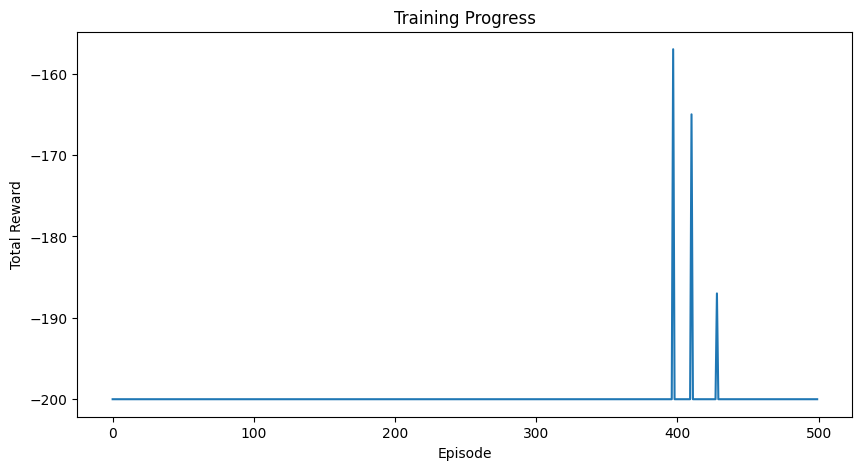

In [8]:
def plot_stats(stats):
    plt.figure(figsize=(10, 5))
    plt.plot(stats['Returns'])
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.show()

plot_stats(stats)

### 5.2 가치 함수 시각화

학습된 신경망이 상태 공간(위치, 속도)에 대해 어떤 가치를 매기고 있는지 3D 그래프로 확인한다.

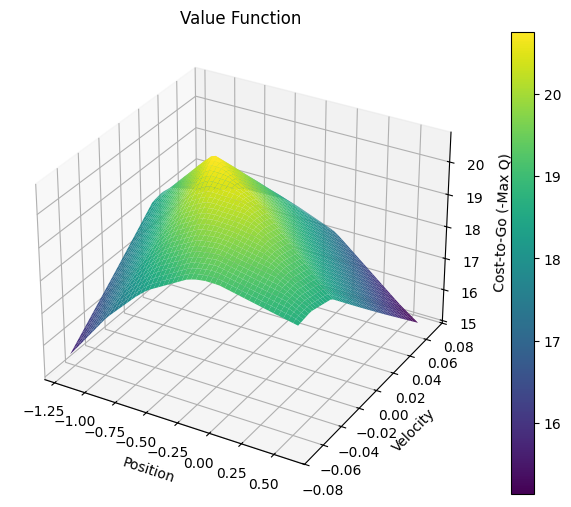

In [9]:
def plot_cost_to_go(env, model, xlabel, ylabel):
    # 그리드 생성
    positions = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
    velocities = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)
    X, Y = np.meshgrid(positions, velocities)

    # 각 그리드 포인트에 대한 Q값 예측
    costs = np.zeros_like(X)
    model.eval()
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                state = np.array([X[i, j], Y[i, j]])
                tensor_state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                q_values = model(tensor_state)
                # Cost는 -Max Q (보상이 음수이므로)
                costs[i, j] = -torch.max(q_values).item()

    # 시각화
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, costs, cmap='viridis', edgecolor='none')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel('Cost-to-Go (-Max Q)')
    ax.set_title('Value Function')
    fig.colorbar(surf)
    plt.show()

plot_cost_to_go(env.unwrapped, q_network, 'Position', 'Velocity')

### 5.3 에이전트 테스트

학습된 모델을 이용하여 에이전트가 실제로 언덕을 잘 올라가는지 확인한다.

Episode 2 finished in 200 steps.


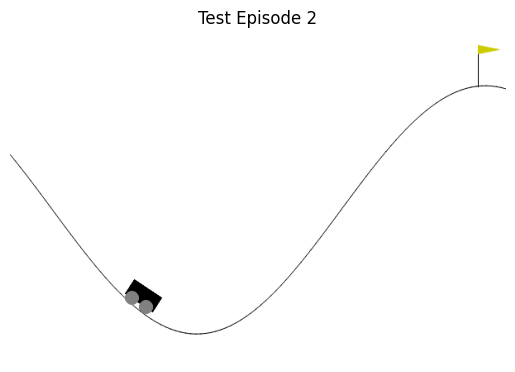

In [10]:
def test_agent(env, policy, episodes=3):
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        step = 0

        img = plt.imshow(env.render())
        plt.axis('off')
        plt.title(f"Test Episode {ep+1}")

        while not done:
            # 테스트 시에는 탐험 없이 Greedy하게 행동 (epsilon=0)
            action = policy(state, epsilon=0.0)
            state, reward, done, truncated, _ = env.step(action)

            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
            step += 1

        print(f"Episode {ep+1} finished in {step} steps.")

from IPython import display
test_agent(env, policy, episodes=2)
env.close()